
Label distribution:
             Count  Percent
risk_label                
Stable         68     85.0
High-Risk      12     15.0

Label distribution by bank (%):
                  Stable  High-Risk
bank                              
Bank of America    85.0       15.0
Citigroup          70.0       30.0
JPMorgan Chase     95.0        5.0
Wells Fargo        90.0       10.0


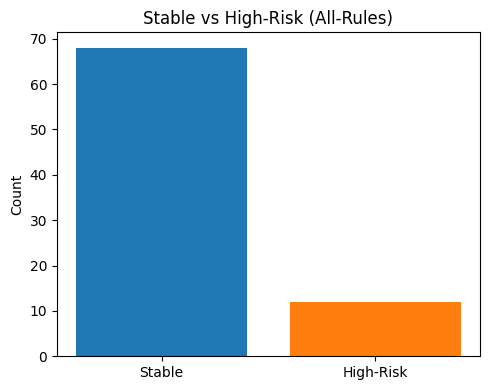

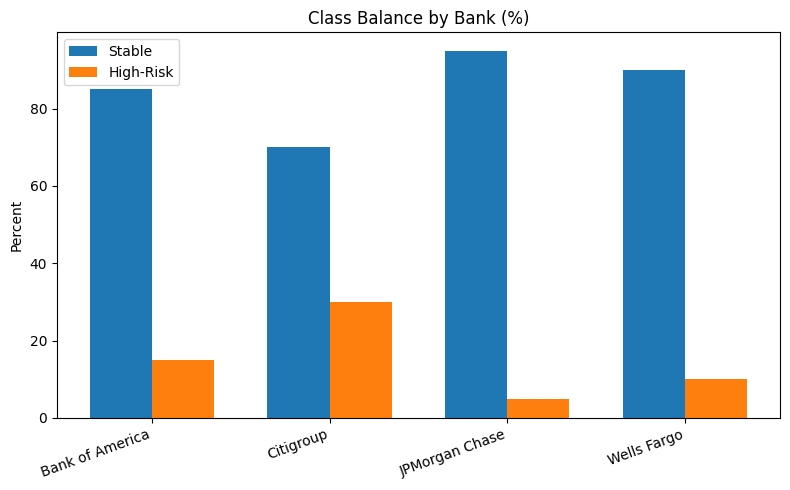

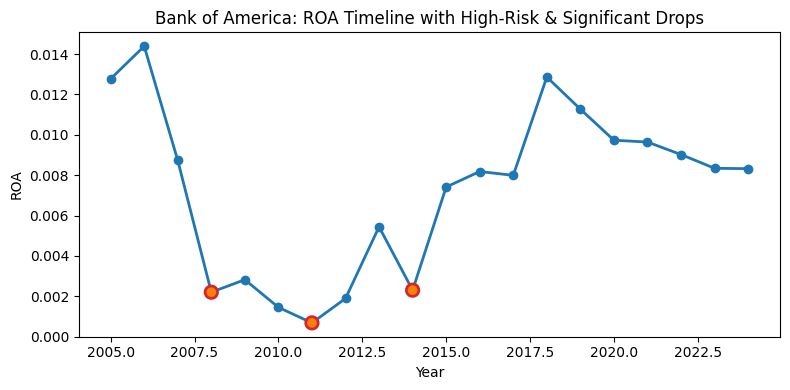

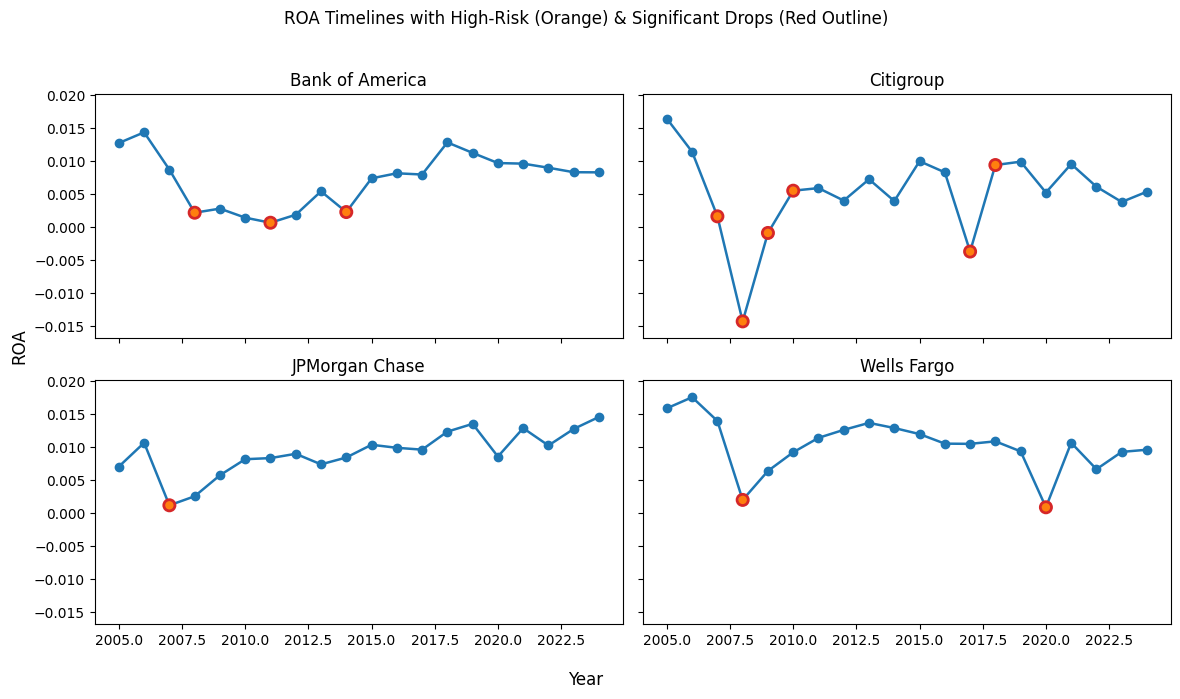

ROA_src — Median Stable: 0.0095 | Median High-Risk: 0.0014 | Δ=0.0081


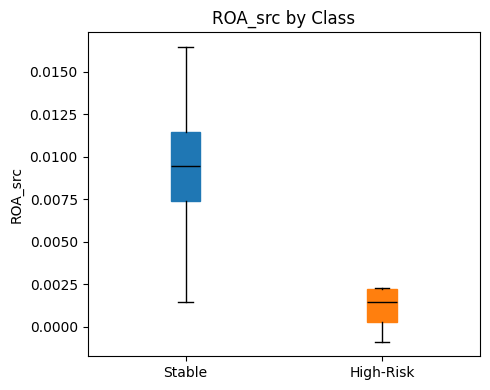

ROE_src — Median Stable: 0.0988 | Median High-Risk: 0.0173 | Δ=0.0815


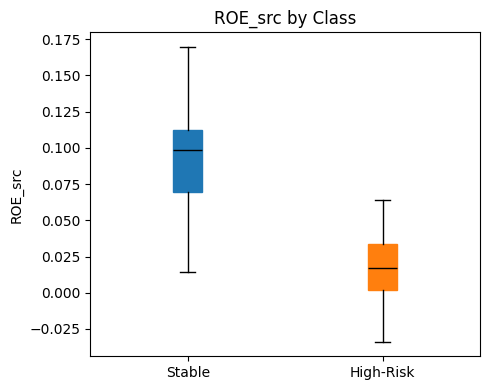

PM_src — Median Stable: 0.2178 | Median High-Risk: 0.0362 | Δ=0.1815


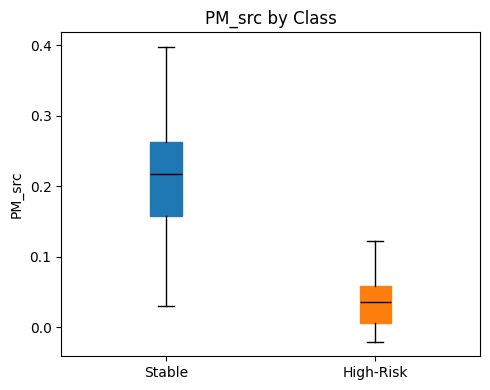

ETA_src — Median Stable: 0.0957 | Median High-Risk: 0.0909 | Δ=0.0049


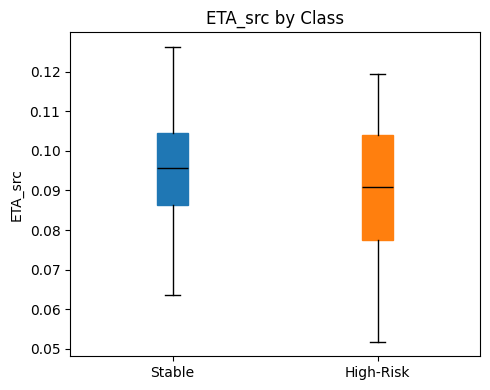

ATO_src — Median Stable: 0.0420 | Median High-Risk: 0.0400 | Δ=0.0020


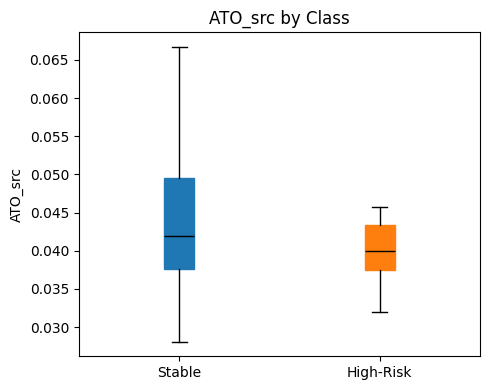

NI_src — Median Stable: 18167.5000 | Median High-Risk: 2270.0000 | Δ=15897.5000


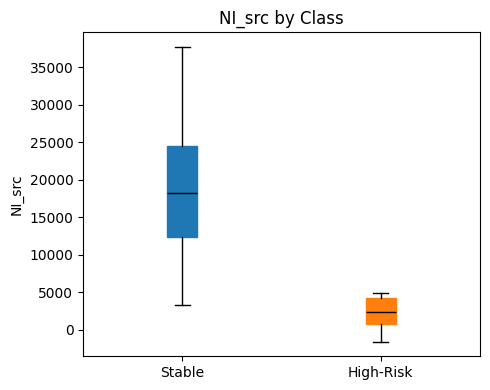

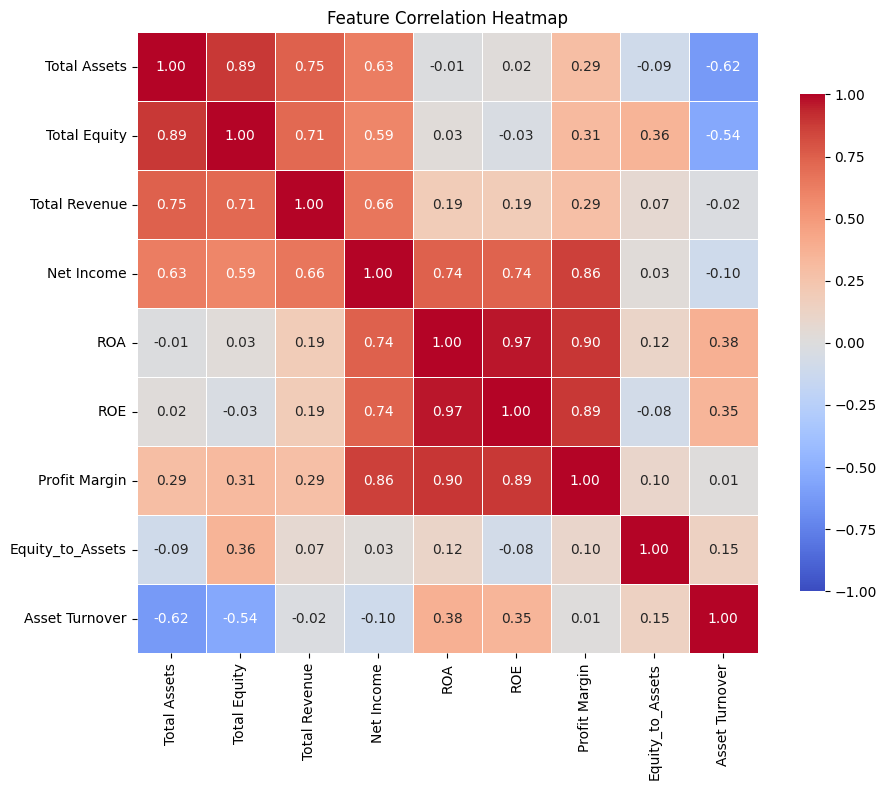

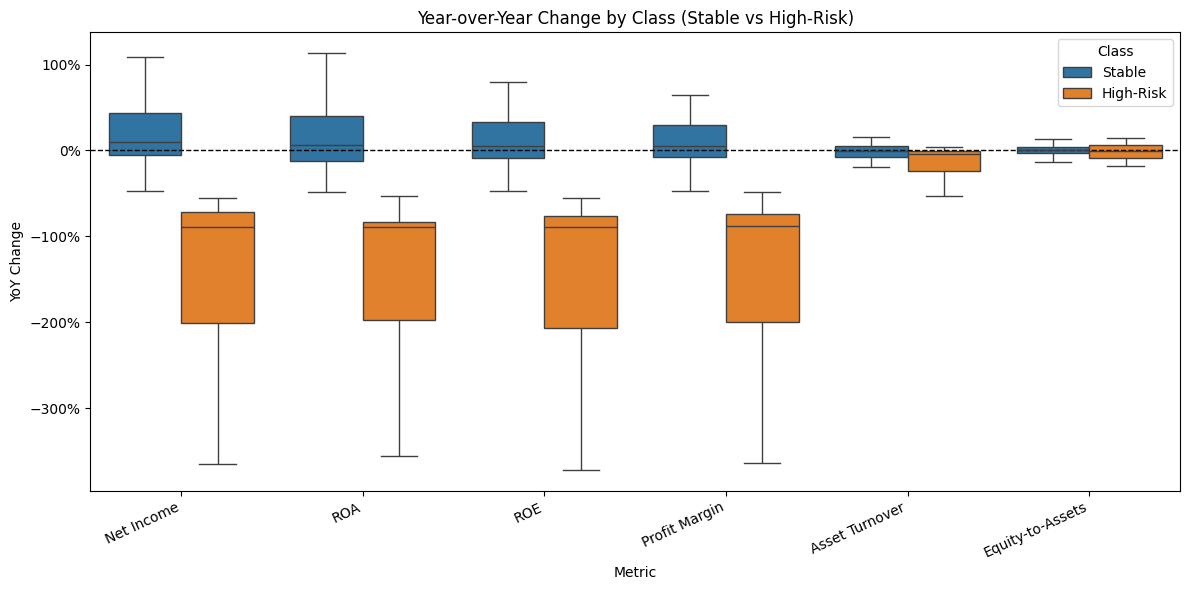

Net Income: Median Stable = 9.909%, Median High-Risk = -88.542%, Δ = +98.451%
ROA: Median Stable = 6.224%, Median High-Risk = -89.495%, Δ = +95.719%
ROE: Median Stable = 5.042%, Median High-Risk = -88.872%, Δ = +93.915%
Profit Margin: Median Stable = 5.258%, Median High-Risk = -87.992%, Δ = +93.250%
Asset Turnover: Median Stable = -0.605%, Median High-Risk = -4.309%, Δ = +3.705%
Equity-to-Assets: Median Stable = 0.787%, Median High-Risk = -0.559%, Δ = +1.346%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.ticker import PercentFormatter

CANDIDATES = ["Big4_Banks_2005_2024_labeled.csv", "Big4_Banks_2005_2024_combined.csv"]

COLUMN_MAP = {
    "bank": ["bank","Bank","institution","Institution","name","Name","ticker","Ticker","Company","Company Name","company","company_name"],
    "year": ["year","Year","fiscal_year","Fiscal Year","FiscalYear"],
    "NI":   ["Net Income","Net_Income","NetIncome","net_income","NI","ni","Net income","netIncome"],
    "ROA":  ["ROA","roa","Return on Assets","Return_on_Assets","return_on_assets"],
    "ROE":  ["ROE","roe","Return on Equity","Return_on_Equity","return_on_equity"],
    "PM":   ["Profit Margin","profit_margin","Profit_Margin","margin","Margin"],
    "ETA":  ["Equity_to_Assets","Equity to Assets","equity_to_assets","Equity/Assets","Equity-to-Assets"],
    "ATO":  ["Asset Turnover","asset_turnover","Asset_Turnover","Turnover"]
}

PALETTE = {"Stable":"#1f77b4","High-Risk":"#ff7f0e"}
BLUE, ORANGE, RED = "#1f77b4", "#ff7f0e", "#d62728"

def first_file(paths):
    for p in paths:
        if Path(p).exists():
            return p
    raise FileNotFoundError(paths)

def pick(df, opts):
    for c in opts:
        if c in df.columns:
            return c

def standardize(df):
    b = pick(df, COLUMN_MAP["bank"])
    y = pick(df, COLUMN_MAP["year"])
    if b != "bank": df["bank"] = df[b]
    if y != "year": df["year"] = df[y]
    for k in ["NI","ROA","ROE","PM","ETA","ATO"]:
        src = pick(df, COLUMN_MAP[k])
        if src is not None and f"{k}_src" not in df.columns:
            df[f"{k}_src"] = pd.to_numeric(df[src], errors="coerce")
    return df

def add_pct_changes(df, by="bank"):
    df = df.sort_values([by, "year"])
    for k in ["NI","ROA","ROE","PM","ATO"]:
        col = f"{k}_src"
        if col in df.columns:
            df[f"{col}_pct_change"] = df.groupby(by)[col].pct_change()
    return df

def build_labels(df, decline_thresh=-0.5, eta_thresh=0.05):
    cond_profit = (
        (df.get("NI_src")  <= 0) |
        (df.get("ROA_src") <= 0) |
        (df.get("ROE_src") <= 0) |
        (df.get("PM_src")  <= 0)
    )
    cond_declines = False
    for k in ["NI","ROA","ROE","PM","ATO"]:
        pc = df.get(f"{k}_src_pct_change")
        if pc is not None:
            cond_declines = cond_declines | (pc <= decline_thresh)
    cond_leverage = df.get("ETA_src") <= eta_thresh if "ETA_src" in df.columns else False
    df["risk_label"] = (pd.Series(cond_profit).fillna(False) | pd.Series(cond_declines).fillna(False) | pd.Series(cond_leverage).fillna(False)).astype(int)
    return df

def label_tables(df):
    label_map = {0:"Stable",1:"High-Risk"}
    counts = df["risk_label"].value_counts().reindex([0,1]).fillna(0).astype(int)
    perc = (counts / counts.sum() * 100).round(2)
    tbl_overall = pd.DataFrame({"Count": counts, "Percent": perc})
    tbl_overall.index = tbl_overall.index.map(label_map)
    grp = df.groupby(["bank","risk_label"]).size().unstack(fill_value=0).reindex(columns=[0,1]).fillna(0)
    grp_perc = (grp.div(grp.sum(axis=1), axis=0) * 100).round(2)
    grp_perc.columns = ["Stable","High-Risk"]
    return tbl_overall, grp_perc

def plot_overall_bar(tbl_overall):
    x = np.arange(len(tbl_overall))
    plt.figure(figsize=(5,4))
    plt.bar(x, tbl_overall["Count"].values, color=[BLUE, ORANGE])
    plt.xticks(x, tbl_overall.index)
    plt.ylabel("Count")
    plt.title("Stable vs High-Risk (All-Rules)")
    plt.tight_layout()
    plt.show()

def plot_bank_balance(grp_perc):
    banks = grp_perc.index.tolist()
    x = np.arange(len(banks)); w = 0.35
    plt.figure(figsize=(8,5))
    plt.bar(x - w/2, grp_perc["Stable"].values, width=w, label="Stable", color=BLUE)
    plt.bar(x + w/2, grp_perc["High-Risk"].values, width=w, label="High-Risk", color=ORANGE)
    plt.xticks(x, banks, rotation=20, ha="right")
    plt.ylabel("Percent")
    plt.title("Class Balance by Bank (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def pick_name(df, candidates):
    vals = set(df["bank"].unique())
    for c in candidates:
        if c in vals:
            return c
    return df["bank"].iloc[0]

def plot_roa_timelines(df):
    metric = "ROA_src" if "ROA_src" in df.columns else pick(df, COLUMN_MAP["ROA"])
    dfp = df[["bank","year",metric,"risk_label"]].dropna().copy()
    dfp["year"] = pd.to_numeric(dfp["year"], errors="coerce")
    dfp = dfp.sort_values(["bank","year"])
    dfp["pct_change"] = dfp.groupby("bank")[metric].pct_change()
    key = pick_name(dfp, ["Bank of America","BAC","Bank of America Corporation"])
    s = dfp[dfp["bank"] == key]
    plt.figure(figsize=(8,4))
    plt.plot(s["year"], s[metric], marker="o", linewidth=2, color=BLUE)
    m_hr = s["risk_label"]==1
    m_sd = s["pct_change"]<=-0.5
    plt.scatter(s.loc[m_hr,"year"], s.loc[m_hr,metric], s=60, color=ORANGE, zorder=3)
    plt.scatter(s.loc[m_sd,"year"], s.loc[m_sd,metric], s=80, facecolors="none", edgecolors=RED, linewidths=2, zorder=4)
    plt.title(f"{key}: ROA Timeline with High-Risk & Significant Drops")
    plt.xlabel("Year"); plt.ylabel("ROA"); plt.tight_layout(); plt.show()

    banks = sorted(dfp["bank"].unique().tolist(), key=str.lower)[:4]
    fig, axes = plt.subplots(2,2, figsize=(12,7), sharex=True, sharey=True)
    axes = axes.flatten()
    y = dfp[metric].values
    pad = (np.nanmax(y)-np.nanmin(y))*0.08 if np.nanmax(y)>np.nanmin(y) else 0.01
    for ax, b in zip(axes, banks):
        ss = dfp[dfp["bank"]==b]
        ax.plot(ss["year"], ss[metric], marker="o", linewidth=1.8, color=BLUE)
        m_hr = ss["risk_label"]==1
        m_sd = ss["pct_change"]<=-0.5
        ax.scatter(ss.loc[m_hr,"year"], ss.loc[m_hr,metric], s=45, color=ORANGE, zorder=3)
        ax.scatter(ss.loc[m_sd,"year"], ss.loc[m_sd,metric], s=65, facecolors="none", edgecolors=RED, linewidths=2, zorder=4)
        ax.set_title(b); ax.set_ylim(np.nanmin(y)-pad, np.nanmax(y)+pad)
    for j in range(len(banks), 4): fig.delaxes(axes[j])
    fig.suptitle("ROA Timelines with High-Risk (Orange) & Significant Drops (Red Outline)", y=0.98)
    fig.supxlabel("Year"); fig.supylabel("ROA"); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

def feature_boxplots(df):
    feats = [c for c in ["ROA_src","ROE_src","PM_src","ETA_src","ATO_src","NI_src"] if c in df.columns]
    for feat in feats:
        med_s = df.loc[df["risk_label"]==0, feat].median()
        med_r = df.loc[df["risk_label"]==1, feat].median()
        print(f"{feat} — Median Stable: {med_s:.4f} | Median High-Risk: {med_r:.4f} | Δ={med_s-med_r:.4f}")
        data = [df.loc[df["risk_label"]==0, feat].dropna(), df.loc[df["risk_label"]==1, feat].dropna()]
        plt.figure(figsize=(5,4))
        bp = plt.boxplot(data, tick_labels=["Stable","High-Risk"], showfliers=False, patch_artist=True)
        bp["boxes"][0].set(facecolor=BLUE, edgecolor=BLUE)
        bp["boxes"][1].set(facecolor=ORANGE, edgecolor=ORANGE)
        for w in bp["whiskers"]+bp["caps"]+bp["medians"]:
            w.set(color="black")
        plt.title(f"{feat} by Class"); plt.ylabel(feat); plt.tight_layout(); plt.show()

def corr_heatmap(df):
    base = ["Total Assets","Total Equity","Total Revenue","Net Income","ROA","ROE","Profit Margin","Equity_to_Assets","Asset Turnover"]
    df_num = df[[c for c in base if c in df.columns]].apply(pd.to_numeric, errors="coerce")
    corr = df_num.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1,
                linewidths=0.5, linecolor="white", square=True, cbar_kws={"shrink":0.8})
    plt.title("Feature Correlation Heatmap"); plt.tight_layout(); plt.show()

def yoy_boxplots(df):
    srcs = ["Net Income","ROA","ROE","Profit Margin","Asset Turnover","Equity_to_Assets"]
    df = df.sort_values(["bank","year"])
    for s in srcs:
        if s in df.columns:
            df[f"{s}_YoY"] = df.groupby("bank")[s].pct_change()
    yoy_cols = [c for c in df.columns if c.endswith("_YoY")]
    name_map = {
        "Net Income_YoY":"Net Income","ROA_YoY":"ROA","ROE_YoY":"ROE",
        "Profit Margin_YoY":"Profit Margin","Asset Turnover_YoY":"Asset Turnover","Equity_to_Assets_YoY":"Equity-to-Assets"
    }
    use_cols = [c for c in yoy_cols if c in name_map]
    df_long = df.melt(id_vars=["bank","year","risk_label"], value_vars=use_cols, var_name="Feature", value_name="YoY Change").dropna(subset=["YoY Change"])
    df_long["Class"] = df_long["risk_label"].map({0:"Stable",1:"High-Risk"})
    df_long["Feature"] = df_long["Feature"].map(name_map)
    order_feats = [name_map[k] for k in use_cols]
    plt.figure(figsize=(12,6))
    ax = sns.boxplot(data=df_long, x="Feature", y="YoY Change", hue="Class",
                     hue_order=["Stable","High-Risk"], order=order_feats, palette=PALETTE, showfliers=False)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title("Year-over-Year Change by Class (Stable vs High-Risk)")
    plt.xlabel("Metric"); plt.ylabel("YoY Change"); plt.xticks(rotation=25, ha="right"); plt.legend(title="Class")
    plt.tight_layout(); plt.show()
    for feat in order_feats:
        key = [k for k,v in name_map.items() if v==feat][0]
        ms = df.loc[df["risk_label"]==0, key].median()
        mr = df.loc[df["risk_label"]==1, key].median()
        print(f"{feat}: Median Stable = {ms:.3%}, Median High-Risk = {mr:.3%}, Δ = {(ms-mr):+.3%}")

def main():
    path = first_file(CANDIDATES)
    df = pd.read_csv(path)
    df = standardize(df)
    df = add_pct_changes(df)
    df = build_labels(df)
    tbl_overall, grp_perc = label_tables(df)
    print("\nLabel distribution:\n", tbl_overall)
    print("\nLabel distribution by bank (%):\n", grp_perc)
    plot_overall_bar(tbl_overall)
    plot_bank_balance(grp_perc)
    plot_roa_timelines(df)
    feature_boxplots(df)
    corr_heatmap(df.copy())
    yoy_boxplots(df.copy())
    out_path = "Big4_Banks_2005_2024_labeled_allrules.csv"
    df.to_csv(out_path, index=False)

if __name__ == "__main__":
    main()


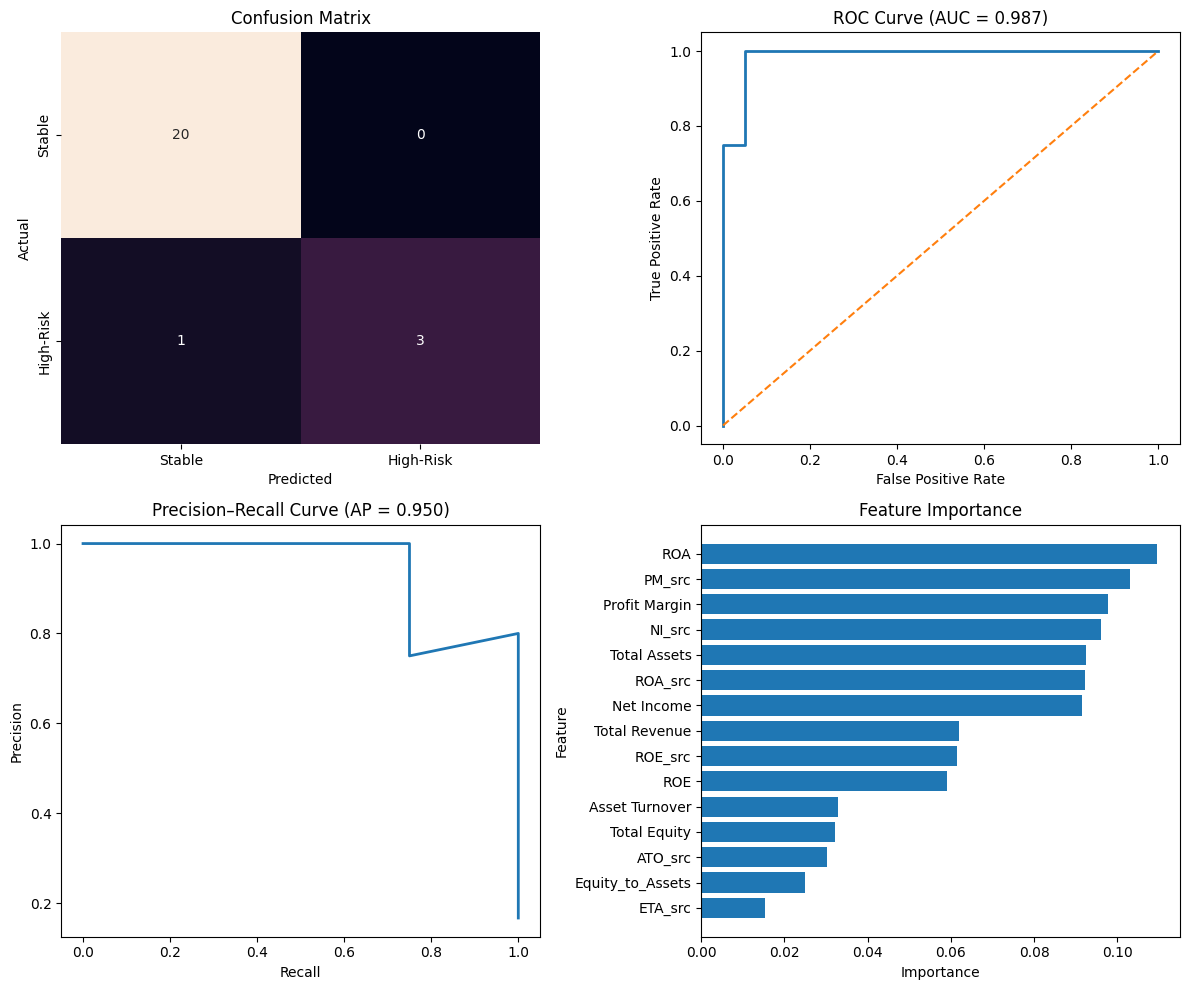

Metric     Score
0       Accuracy  0.958333
1        ROC AUC  0.987500
2  Avg Precision  0.950000

precision  recall  f1-score  support
0                 0.952   1.000     0.976   20.000
1                 1.000   0.750     0.857    4.000
accuracy          0.958   0.958     0.958    0.958
macro avg         0.976   0.875     0.916   24.000
weighted avg      0.960   0.958     0.956   24.000

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("Big4_Banks_2005_2024_labeled_allrules.csv")

df["risk_label"] = df["risk_label"].astype(int)


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

feat_candidates = ["ROA_src","ROE_src","PM_src","ETA_src","ATO_src","NI_src","Total Assets","Total Equity","Total Revenue","Net Income","ROA","ROE","Profit Margin","Equity_to_Assets","Asset Turnover"]
X_cols = [c for c in feat_candidates if c in df.columns]
X = df[X_cols].apply(pd.to_numeric, errors="coerce").fillna(df[X_cols].median(numeric_only=True))
y = df["risk_label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
rep = classification_report(y_test, y_pred, output_dict=True)
rep_df = pd.DataFrame(rep).T

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=axes[0,0], xticklabels=["Stable","High-Risk"], yticklabels=["Stable","High-Risk"])
axes[0,0].set_title("Confusion Matrix")
axes[0,0].set_xlabel("Predicted")
axes[0,0].set_ylabel("Actual")

fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[0,1].plot(fpr, tpr, linewidth=2)
axes[0,1].plot([0,1],[0,1], linestyle="--")
axes[0,1].set_title(f"ROC Curve (AUC = {auc:.3f})")
axes[0,1].set_xlabel("False Positive Rate")
axes[0,1].set_ylabel("True Positive Rate")

prec, rec, _ = precision_recall_curve(y_test, y_prob)
axes[1,0].plot(rec, prec, linewidth=2)
axes[1,0].set_title(f"Precision–Recall Curve (AP = {ap:.3f})")
axes[1,0].set_xlabel("Recall")
axes[1,0].set_ylabel("Precision")

imp = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=True)
axes[1,1].barh(imp.index, imp.values)
axes[1,1].set_title("Feature Importance")
axes[1,1].set_xlabel("Importance")
axes[1,1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

display(pd.DataFrame({"Metric":["Accuracy","ROC AUC","Avg Precision"],"Score":[acc, auc, ap]}))
display(rep_df.round(3))
